In [2]:
from typing import (Tuple,List,Dict,Union)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [11]:
# import torch
# from torch.nn import (Tanh,ReLU)

# def dynamics(y_t:torch.tensor,sigma):
    
#     a,b = y_t
#     y_next = torch.zeros_like(y_t)
#     size = y_t.shape[1]
#     relu = ReLU()

#     y_next[0] =  1.0 * torch.tanh(a) + 0.8 * a * b + 1.0 * b - 1.0 * relu(torch.minimum(a,b)) + sigma * torch.randn(size)
#     y_next[1] = 0.6 * torch.sign(b) + 0.5 * a * b - 1.0 * torch.maximum(a,b) + sigma * torch.randn(size)
    
#     return y_next

# sigma_true = 0.1

# T_total = 2000
# y = torch.zeros((2, T_total))
# y_without_noise = torch.zeros((2, T_total))

# name_stock = dynamics(y,sigma_true)
# noise = dynamics(name_stock,0)


# # Nomura = name_stock[0]
# # PFN = name_stock[1]
# name_stock[:,0] = torch.tensor([0.5,0.5])
# noise[:,0] = torch.tensor([0.5,-0.5])
# name_stock_label = ["Nomura", "PFN"]

# plt.figure(figsize=(18,5))
# plt.xlim([T_total-100,T_total])
# plt.plot(name_stock[0].numpy(), color = "#cc0000", label = name_stock_label[0])
# plt.plot(name_stock[1].numpy(), color = "#083090", label = name_stock_label[1])
# plt.plot(noise[0].numpy(), color = "#cc0000", linestyle = "--", label = name_stock_label[0] + "(w/o noise)")
# plt.plot(noise[1].numpy(), color = "#083090", linestyle = "--", label = name_stock_label[1] + "(w/o noise)")
# plt.xlabel("time", fontsize = 18)
# plt.ylabel("y", fontsize = 18)
# plt.legend()

In [10]:
def identity(x):
    return x


def ReLU(x: np.ndarray) -> np.ndarray:

    return np.where(x > 0, x, 0)


def sign(x: np.ndarray) -> np.ndarray:

    return np.where(x > 0, 1, 0)


def unary_x(x, y):
    return x



activation_func_dic: Dict = {
    'identity': identity,
    'tanh': np.tanh,
    'exp': np.exp,
    'sign': sign,
    'ReLU': ReLU
}
binary_operator_func_dic: Dict = {
    'max': np.max,
    'min': np.min,
    'sum': np.sum,
    'diff': np.diff,
    'mul': np.multiply,
    'unary_x': unary_x,
}


def dynamics(y_t: np.ndarray, sigma: float) -> np.ndarray:

    a, b = y_t
    size = y.shape[1]
    y_next = np.zeros_like(y_t)

    y_next[0] = 1. * np.tanh(a) + 0.8 * np.multiply(a, b) + 1. * b - 1. * ReLU(
        np.minimum(a, b)) + sigma * np.random.randn(size)

    y_next[1] = 0.6 * sign(b) + 0.5 * np.multiply(a, b) - 1.0 * np.maximum(
        a, b) + sigma * np.random.randn(size)

    return y_next

In [11]:
T_total = 2000
sigma_true = 0.1

y = np.zeros((2, T_total))

name_stock_label = ["Nomura", "PFN"]

name_stock = dynamics(y,sigma_true)
noise = dynamics(name_stock,0)

name_stock[:,0] = np.array([0.5,0.5])

Nomura = name_stock[0]
PFN = name_stock[1]

noise[:,0] = np.array([0.5,-0.5])


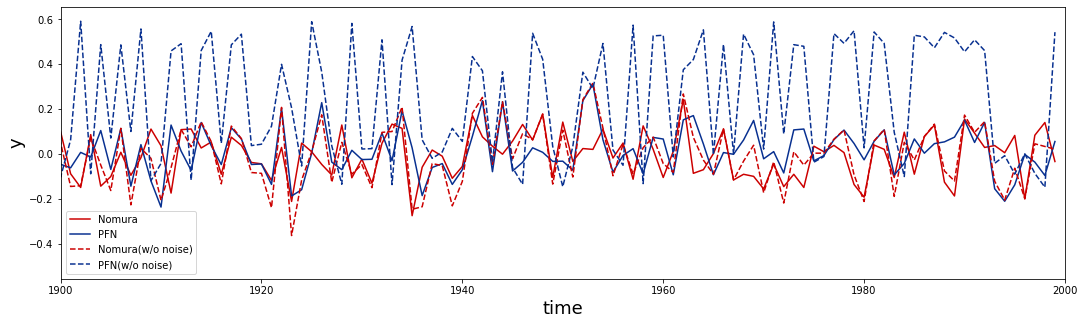

In [12]:
plt.figure(figsize=(18, 5))
plt.xlim([T_total - 100, T_total])
plt.plot(Nomura, color="#cc0000", label=name_stock_label[0])
plt.plot(PFN, color="#083090", label=name_stock_label[1])

plt.plot(noise[0],
         color="#cc0000",
         ls="--",
         label=name_stock_label[0] + "(w/o noise)")

plt.plot(noise[1],
         color="#083090",
         ls="--",
         label=name_stock_label[1] + "(w/o noise)")

plt.xlabel("time", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.legend()


In [71]:
time_window = 100
delay_max = 2
num_stock = len(name_stock_label)

name_binary_operator = list(binary_operator_func_dic.keys())
name_activation = list(activation_func_dic.keys())


class Trader:
    def __init__(self, num_factors_max=4, delay_max=2):

        # Num_factor _max 是 formula 中包含的项的最大值
        self.num_factors_max = num_factors_max

        # delay _max 可以使用多少历史数据
        self.delay_max = delay_max

        self.num_factors = [[] for _ in range(num_stock)]
        self.delay_x = [[] for _ in range(num_stock)]
        self.delay_y = [[] for _ in range(num_stock)]
        self.stock1 = [[] for _ in range(num_stock)]
        self.stock2 = [[] for _ in range(num_stock)]
        self.w = [[] for _ in range(num_stock)]
        self.activation = [[] for _ in range(num_stock)]
        self.binary_operator = [[] for _ in range(num_stock)]
        self.X_factor = [[] for _ in range(num_stock)]
        self.cumulative_error = [[] for _ in range(num_stock)]

        for target in range(num_stock):
            self.num_factors[target] = np.random.choice(
                range(1, self.num_factors_max + 1))

            self.delay_x[target] = np.random.choice(delay_max,
                                                    self.num_factors[target])
            self.delay_y[target] = np.random.choice(delay_max,
                                                    self.num_factors[target])

            self.stock1[target] = [
                np.random.choice(num_stock)
                for _ in range(self.num_factors[target])
            ]
            self.stock2[target] = [
                np.random.choice(num_stock)
                for _ in range(self.num_factors[target])
            ]

            self.activation[target] = [
                np.random.choice(name_activation)
                for _ in range(self.num_factors[target])
            ]
            self.binary_operator[target] = np.random.choice(
                name_binary_operator, self.num_factors[target])

            self.w[target] = np.random.randn(self.num_factors[target])
            self.X_factor[target] = np.zeros((0, self.num_factors[target]))

            self.cumulative_error[target] = 0.0

    def reset_parameters(self, target):  # ファクターの行列Xがランク落ちした際に必要
        self.num_factors[target] = np.random.choice(
            range(1, self.num_factors_max + 1))

        self.delay_x[target] = np.random.choice(delay_max,
                                                self.num_factors[target])
        self.delay_y[target] = np.random.choice(delay_max,
                                                self.num_factors[target])

        self.stock1[target] = [
            np.random.choice(num_stock)
            for _ in range(self.num_factors[target])
        ]
        self.stock2[target] = [
            np.random.choice(num_stock)
            for _ in range(self.num_factors[target])
        ]

        self.activation[target] = [
            np.random.choice(name_activation)
            for _ in range(self.num_factors[target])
        ]
        self.binary_operator[target] = np.random.choice(
            name_binary_operator, self.num_factors[target])
        self.w[target] = np.random.randn(self.num_factors[target])
        self.X_factor[target] = np.zeros((0, self.num_factors[target]))

        self.cumulative_error[target] = 0.0

    def calc_factor(self, target, j, data):  # traderが持つ，targetに対するj番目のファクターを計算
        A = activation_func_dic[self.activation[target][j]]  # 可読性のため代入，以下同様
        O = binary_operator_func_dic[self.binary_operator[target][j]]
        P = self.stock1[target][j]
        Q = self.stock2[target][j]
        D = self.delay_x[target][j]
        F = self.delay_y[target][j]
        return A(O(data[P][self.delay_max - D],
                   data[Q][self.delay_max - F]))  # 論文の式と対応している形

    def stack_factors(self, data_to_stack,
                      target):  # Companyのメソッドeducationのために必要なデータをstackしておく
        factors = np.zeros(self.num_factors[target])
        for j in range(self.num_factors[target]):  # 各ファクターごとに
            factors[j] = self.calc_factor(target, j, data_to_stack)
        if len(self.X_factor[target]
               ) < time_window:  # time_windowよりもデータがたまっていないときは，ただ下に積むだけ．
            self.X_factor[target] = np.vstack([self.X_factor[target], factors])
        else:  # time_windowよりもデータがたまっているときは，下に積みつつ過去のデータを消してしまう．
            self.X_factor[target] = np.roll(self.X_factor[target], -1, axis=0)
            self.X_factor[target][-1] = factors

    # y = (y_{t-w-1}, , y_t)
    def learn(self, target,
              y):  # 最小二乗法により，各ファクターの係数を最適化する．X_factorを使っていることに注意．
        epsilon = 0.0001  # singular matrixが生じないための工夫
        X = self.X_factor[target]
        if np.linalg.matrix_rank(X.T.dot(X) +
                                 epsilon) < self.num_factors[target]:
            #print("Note: rank(X_factor) < num_factors.")
            self.w[target] = np.zeros(len(self.w[target]))
        else:
            self.w[target] = np.linalg.inv(X.T.dot(X) + epsilon).dot(X.T).dot(
                y)  # 最小二乗法で係数を求めている

    # prediction.shape = (num_stock, time_window)
    def predict_for_train(
        self
    ):  # train dataに対するprediction, これに基づいてcumulative_errorを計算し，bad_traderを解雇する．
        prediction = np.zeros(
            (num_stock, time_window
             ))  # 過去のデータに対して行うため，prediction.shape = (num_stock, time_window)
        for target in range(num_stock):
            prediction[target] = self.X_factor[target].dot(self.w[target])
        return prediction

    def predict_for_test(self):  # test dataに対するprediction, これに基づいてモデルの評価を行う．
        prediction = np.zeros(
            num_stock)  # 各時刻に対して行うため，prediction.shape  (num_stock)
        for target in range(num_stock):
            prediction[target] = self.X_factor[target][-1].dot(self.w[target])
        return prediction

    def calc_cumulative_error(
            self,
            y_true):  # 過去のデータに対してcumulative_errorを計算，これに基づいてbad_traderを見つける．
        prediction = self.predict_for_train(
        )  # prediction.shape = (num_stock, time_window)
        errors = (prediction - y_true)**2.0
        errors = np.sqrt(errors.mean(1))  # errorsを時間軸方向について平均
        for target in range(num_stock):
            self.cumulative_error[target] = errors[target]

In [72]:
trade = Trader()

In [86]:
trade.delay_x

[array([0, 0]), array([0, 0, 0, 1])]

In [81]:
max_factors_num: int = 4
stock_num: int = 2
name_activation: List = ["identity", "tanh", "sign", "ReLU"]
name_binary_operator: List = ["sum", "x_times_y", "unary_x", "max", "min"]
delay_max = 2
time_window = 100


class My_Trader():
    def __init__(self,
                 stock_num: int,
                 max_factors_num: int,
                 delay_max: int,
                 time_window: int,
                 name_activation: List = name_activation,
                 name_binary_operator: List = name_binary_operator):

        self.stock_num = stock_num
        self.time_window = time_window
        # Num_factor _max 是 formula 中包含的项的最大值
        self.num_factors_max = max_factors_num

        # delay _max 可以使用多少历史数据
        self.delay_max = delay_max

        self.num_factors: np.ndarray = np.random.choice(
            np.arange(1, max_factors_num + 1), self.stock_num)

        self.delay_x: List[np.ndarry] = [
            np.random.choice(stock_num, i) for i in self.num_factors
        ]
        self.delay_y: List[np.ndarry] = [
            np.random.choice(stock_num, i) for i in self.num_factors
        ]
        self.stock1: List[np.ndarry] = [
            np.random.choice(stock_num, i) for i in self.num_factors
        ]
        self.stock2: List[np.ndarry] = [
            np.random.choice(stock_num, i) for i in self.num_factors
        ]
        self.activation: List[np.ndarry] = [
            np.random.choice(name_activation, i) for i in self.num_factors
        ]
        self.binary_operator: List[np.ndarry] = [
            np.random.choice(name_binary_operator, i) for i in self.num_factors
        ]

        self.w: List[np.ndarry] = [
            np.random.randn(i) for i in self.num_factors
        ]
        self.X_factor: List[np.ndarry] = [
            np.zeros((0, i)) for i in self.num_factors
        ]
        self.cumulative_error = np.zeros(stock_num)

    def reset_parameters(self, target: int):

        self.num_factors[target] = np.random.choice(
            range(1, self.num_factors_max + 1))

        self.delay_x[target] = np.random.choice(delay_max,
                                                self.num_factors[target])
        self.delay_y[target] = np.random.choice(delay_max,
                                                self.num_factors[target])

        self.stock1[target] = np.random.choice(num_stock,
                                               self.num_factors[target])
        self.stock2[target] = np.random.choice(num_stock,
                                               self.num_factors[target])

        self.activation[target] = np.random.choice(name_activation,
                                                   self.num_factors[target])

        self.binary_operator[target] = np.random.choice(
            name_binary_operator, self.num_factors[target])

        self.w[target] = np.random.randn(self.num_factors[target])
        self.X_factor[target] = np.zeros((0, self.num_factors[target]))

    def calc_factor(self, target: int, j: int, data):

        A: float = activation_func_dic[self.activation[target][j]]
        O: float = binary_operator_func_dic[self.binary_operator[target][j]]
        P: float = self.stock1[target][j]
        Q: float = self.stock2[target][j]
        D: float = self.delay_x[target][j]
        F: float = self.delay_y[target][j]

        return A(O(data[P][self.delay_max - D], data[Q][self.delay_max - F]))

    def stack_factors(self, data_to_stack, target):

        factors = np.zeros(self.num_factors[target])

        for j in range(self.num_factors[target]):

            factors[j] = self.calc_factor(target, j, data_to_stack)

        if len(self.X_factor[target]) < time_window:

            self.X_factor[target] = np.vstack([self.X_factor[target], factors])

        else:

            self.X_factor[target] = np.roll(self.X_factor[target], -1, axis=0)
            self.X_factor[target][-1] = factors

    def learn(self, target, y):
        """最小二乘法对各因子的系数进行优化
        y = (y_{t-w-1}, , y_t)
        Args:
            target (_type_): _description_
            y (_type_): _description_
        """
        epsilon = 0.0001  # 避免奇异矩阵(singular matrix)

        X = self.X_factor[target]
        if np.linalg.matrix_rank(X.T.dot(X) +
                                 epsilon) < self.num_factors[target]:
            #print("Note: rank(X_factor) < num_factors.")
            self.w[target] = np.zeros(len(self.w[target]))
        else:
            self.w[target] = np.linalg.inv(X.T.dot(X) + epsilon).dot(X.T).dot(
                y)  # 用最小二乘法求系数

    # prediction.shape = (num_stock, time_window)
    def predict_for_train(self):
        
        prediction = np.zeros((self.num_stock, self.time_window))
        
        for target in range(num_stock):
            prediction[target] = self.X_factor[target].dot(self.w[target])
        return prediction

In [82]:
my_trader = My_Trader(stock_num,max_factors_num,delay_max,name_activation,name_binary_operator)

[array([1, 1]), array([0, 1, 0, 0])]

In [94]:
num_factors

array([2, 4])